# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Download-forest-Cover" data-toc-modified-id="Download-forest-Cover-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Download forest-Cover</a></div><div class="lev2 toc-item"><a href="#download-health-stress-data" data-toc-modified-id="download-health-stress-data-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>download health stress data</a></div>

Spatial reclasification

In [1]:
import numpy as np
from matplotlib import pyplot
from rasterio.plot import show_hist, show
import os
from sklearn import preprocessing
import rasterio
from rasterio.features import rasterize
from rasterio.rio.main import main_group
from click.testing import CliRunner
import json
import fiona
from fiona.crs import from_epsg
from pyproj import Proj, transform
import geopandas
from rasterio import Affine
from shapely.geometry import Point

In [75]:
def outDir(path):
    pat=path.split('/')
    direct='/'.join(pat[:-1])
    file ='/{0}.tif'.format(pat[-1].split('.')[0])
    return direct+file

### To be able to rasterize a polygon

In [396]:
EXAMPLETIF = '/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Soils/PHIHOX_M_sl1_10km_ll.tif'
def rasterizePolygon(path):
    def runner():
        return CliRunner()
    with fiona.open(path) as source:
        runner = runner()
        output = outDir(path)  
        result = runner.invoke(main_group, ['rasterize', output, '--like', EXAMPLETIF], input=json.dumps({"type": "FeatureCollection", "features":list(source)}))
    assert os.path.exists(output)
    return output

rasterizePolygon('/Users/alicia/Documents/test/wdpa.shp')

'/Users/alicia/Documents/test/wdpa.tif'

### To be able to resample a raster

In [361]:
def resampleRaster(path):
    def runner():
        return CliRunner()
    runner = runner()
    pat=path.split('/')[-1].split('.')
    outfile ='/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/{0}_10km.tif'.format(pat[0]) 
    print(outfile)
    result = runner.invoke(main_group, ['warp', path,  outfile, '--like', EXAMPLETIF, '--resampling', 'average'])
    print(result)
    assert os.path.exists(outfile)
    return outfile

resampleRaster('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Population_distribution_and_growth/gpw_v4_population_density_rev10_2020_2pt5_min.tif')

/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/gpw_v4_population_density_rev10_2020_2pt5_min_10km.tif
<Result okay>


'/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/gpw_v4_population_density_rev10_2020_2pt5_min_10km.tif'

### To be able to manage rasters with linear interpolation

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 3600, 'height': 1400, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.1, 0.0, -180.0,
       0.0, -0.1, 83.99916720600001), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 3600, 'height': 1400, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.1, 0.0, -180.0,
       0.0, -0.1, 83.99916720600001), 'tiled': False, 'interleave': 'band'}
1.0
0.0


<IPython.core.display.Javascript object>


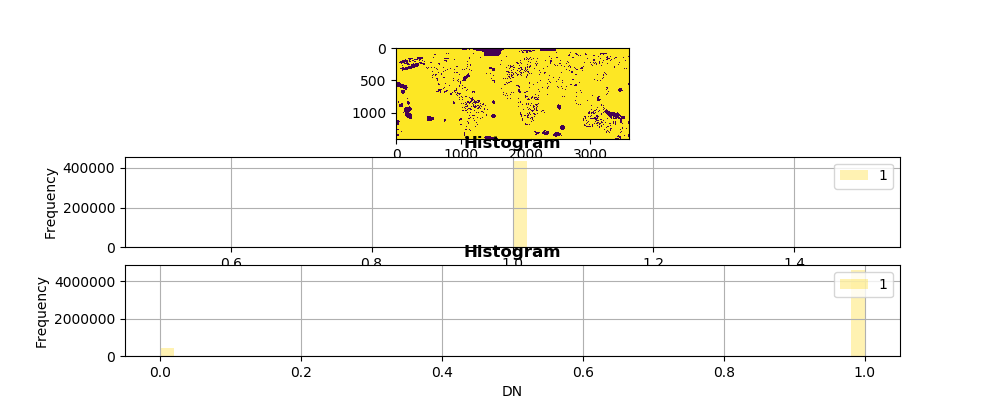

In [397]:
def linear(X):
    data=np.ma.masked_where(X < 0, X) ## mask no data value or areas that we don't want to keep
    MAX=np.max(data)
    MIN=np.min(data)
    print(MAX)
    print(MIN)
    X_std = (X - MIN) / (MAX - MIN)
    X_scaled =1- X_std * (1 - 0) + 0
    return X_scaled

def linearNormalization(image):
    image=image.astype(np.float32)
    transformer = preprocessing.FunctionTransformer(linear)
    scaledImage = transformer.transform(image)
    scaledImage[np.where(scaledImage >1)] = -1
    scaledImage[np.where(scaledImage <0)] = -1
    
    return scaledImage

def manageRasters(path):
    pat=path.split('/')
    outfile ='/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/{0}'.format(pat[-1])
    with rasterio.open(path) as dataset:
        profile = dataset.profile
        print(profile)
        profile['dtype']='float32'
        profile['nodata']= -1
        print(profile)
        with rasterio.open(outfile, 'w', **profile) as output:
            image=dataset.read(1, masked = True)
            data=linearNormalization(image)
            fig, (axrgb, axhist, axhist2) = pyplot.subplots(3, 1, figsize=(10,4))
            #pyplot.imshow(data, cmap='pink',ax=axrgb)
            show(data, ax=axrgb)
            output.write(data, 1)
            show_hist(image, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist)
            show_hist(output.read(1, masked=True), bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist2)
            pyplot.show()
manageRasters('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Natural capital/wdpa.tif')

### To be able to manage the rasters with logaritmic interpolation

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 3600, 'height': 1400, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.1, 0.0, -180.0,
       0.0, -0.1, 83.99916720600001), 'compress': 'lzw', 'interleave': 'band', 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 3600, 'height': 1400, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.1, 0.0, -180.0,
       0.0, -0.1, 83.99916720600001), 'compress': 'lzw', 'interleave': 'band', 'tiled': False}


/Users/alicia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log1p
/Users/alicia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


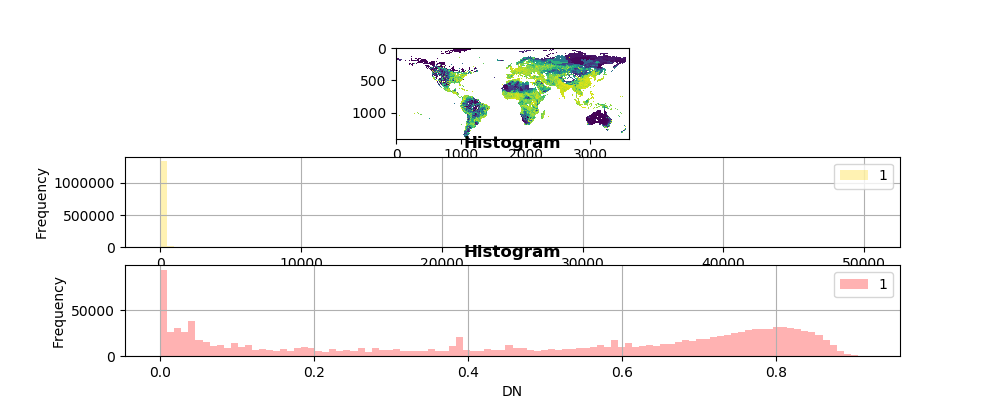

/Users/alicia/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/alicia/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


In [364]:
def logarithm(X):
    X_scaled =1-( 1/(np.log1p(X) + 1))
    return X_scaled

def logNormalization(image):
    image=image.astype(np.float32)
    transformer = preprocessing.FunctionTransformer(logarithm)
    scaledImage = transformer.transform(image)
    scaledImage[np.where(scaledImage >1)] = -1
    scaledImage[np.where(scaledImage <0)] = -1
    return scaledImage.astype(np.float32)

def manageRasters(path):
    pat=path.split('/')
    outfile ='/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/{0}'.format(pat[-1])
    with rasterio.open(path) as dataset:
        profile = dataset.profile
        print(profile)
        profile['dtype']= 'float32'
        profile['nodata']= -1
        print(profile)
        with rasterio.open(outfile, 'w', **profile) as output:
            image=dataset.read(1, masked=True)
            data=logNormalization(image)
            fig, (axrgb, axhist, axhist2) = pyplot.subplots(3, 1, figsize=(10,4))
            show(data, ax=axrgb)
            output.write(data, 1)
            show_hist(image, bins=100, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram", ax=axhist)
            show_hist(output.read(), bins=100, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram", ax=axhist2, masked=True)
            pyplot.show()
manageRasters('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Population_distribution_and_growth/gpw_v4_population_density_rev10_2020_2pt5_min_10km.tif')

### To be able to manage rasters with categorical set up of the data

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 3600, 'height': 1400, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.1, 0.0, -180.0,
       0.0, -0.1, 83.99916720600001), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]
float32


<IPython.core.display.Javascript object>


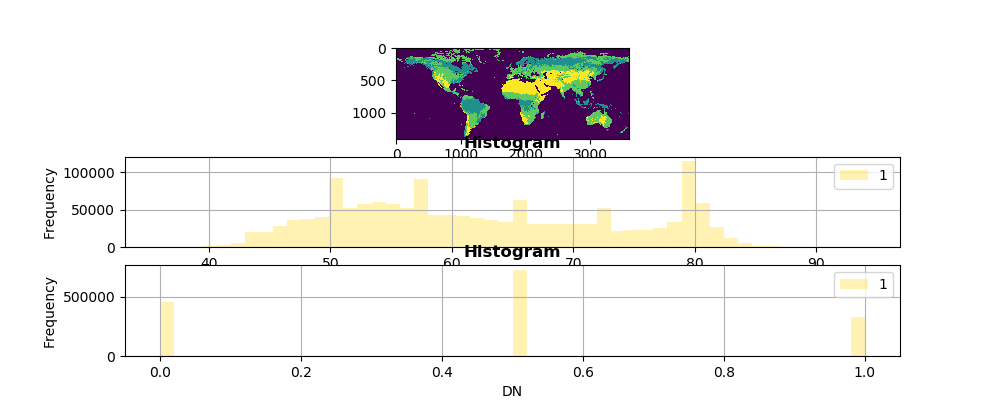

In [367]:
def reclass1(image):
    image=image.astype(np.float32)
    print(image)
    print(image.dtype)
    image[np.where( image < 55 )] = 0
    image[np.where((image >= 55) & (image < 75)) ] = 0.5
    image[np.where((image >= 75) & (image < 255) )] = 1
    image[np.where(image >= 255)] = -1
    return image

def manageRasters(path):
    pat=path.split('/')
    outfile ='/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/{0}'.format(pat[-1])
    with rasterio.open(path) as dataset:
        profile = dataset.profile
        profile['dtype']='float32'
        profile['nodata']= -1
        print(profile)
        with rasterio.open(outfile, 'w', **profile) as output:
            image=dataset.read(1, masked=True)
            data=reclass1(image)
            fig, (axrgb, axhist, axhist2) = pyplot.subplots(3, 1, figsize=(10,4))
            #pyplot.imshow(data, cmap='pink',ax=axrgb)
            show(data, ax=axrgb)
            output.write(data, 1)
            show_hist(image, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist)
            show_hist(output.read(1, masked=True), bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist2 ,masked=True)
            pyplot.show()
manageRasters(EXAMPLETIF)

## Download forest-Cover

```js
var loss = image.select('loss')
var treeCover = image.select('treecover2000').updateMask(loss.not()).updateMask(image.select('treecover2000'))

Map.addLayer(treeCover, {min:0,max:100})
Export.image.toDrive(treeCover, scale=10000)
```

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 4008, 'height': 1735, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.08983152841195215, 0.0, -180.0223829375521,
       0.0, -0.08983152841195215, 79.95006028663741), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
float32


<IPython.core.display.Javascript object>


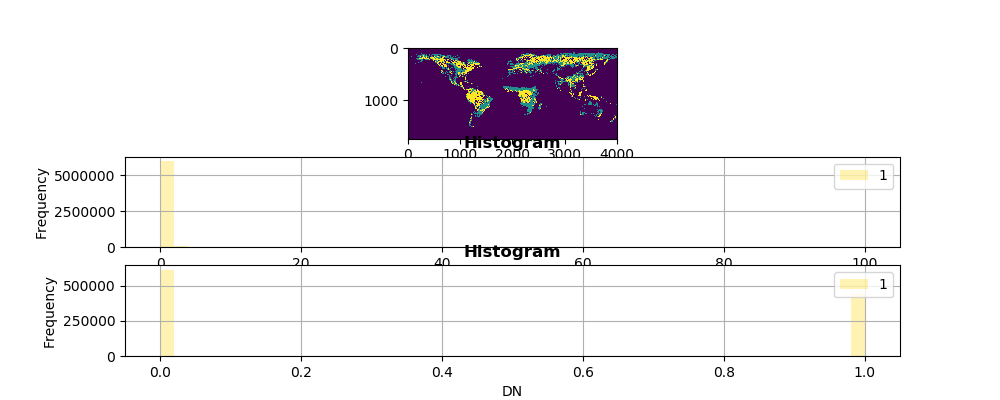

In [398]:
def reclass1(image):
    image=image.astype(np.float32)
    print(image)
    print(image.dtype)
    image[np.where(image == 0)] = -1
    image[np.where((image > 0) & (image < 35) )] = 0
    image[np.where(image >= 35)] = 1
    return image

def manageRasters(path):
    pat=path.split('/')
    outfile ='/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/{0}'.format(pat[-1])
    with rasterio.open(path) as dataset:
        profile = dataset.profile
        profile['dtype']='float32'
        profile['nodata']= -1
        print(profile)
        with rasterio.open(outfile, 'w', **profile) as output:
            image=dataset.read(1, masked=True)
            data=reclass1(image)
            fig, (axrgb, axhist, axhist2) = pyplot.subplots(3, 1, figsize=(10,4))
            #pyplot.imshow(data, cmap='pink',ax=axrgb)
            show(data, ax=axrgb)
            output.write(data, 1)
            show_hist(image, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist)
            show_hist(output.read(1, masked=True), bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist2 ,masked=True)
            pyplot.show()
manageRasters('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Natural capital/forest_cover.tif')

## download health stress data
```json
SELECT  dhs_regions.the_geom, dhs_regions.the_geom_webmercator, dhs_regions.regionid,
cn_nuts_c_ha2 as ha2,
cn_nuts_c_wa2 as wa2,
cn_nuts_c_wh2 as wh2 
FROM dhs_regions inner join dhs_indicators on dhs_regions.regionid=dhs_indicators.regionid
```

In [407]:
EXAMPLETIF = '/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Soils/PHIHOX_M_sl1_10km_ll.tif'
def rasterizePolygon(path):
    def runner():
        return CliRunner()
    with fiona.open(path) as source:
        runner = runner()
        output = outDir(path)  
        result = runner.invoke(main_group, ['rasterize', output, '--like', EXAMPLETIF], input=json.dumps({"type": "FeatureCollection", "features":list(source)}))
    assert os.path.exists(output)
    return output

rasterizePolygon('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Health_stress/dhs_indicators.shp')

'/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Health_stress/dhs_indicators.tif'

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2595, 'height': 904, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.1, 0.0, -118.41669999999999,
       0.0, -0.1, 55.486999999999995), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 2595, 'height': 904, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.1, 0.0, -118.41669999999999,
       0.0, -0.1, 55.486999999999995), 'tiled': False, 'interleave': 'band'}
81.9
0.0


<IPython.core.display.Javascript object>


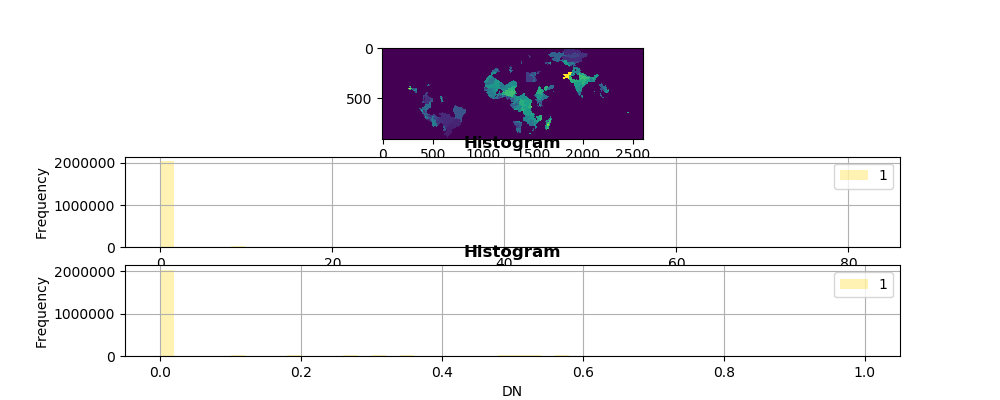

In [413]:
def linear(X):
    data=np.ma.masked_where(X < 0, X) ## mask no data value or areas that we don't want to keep
    MAX=np.max(data)
    MIN=np.min(data)
    print(MAX)
    print(MIN)
    X_std = (X - MIN) / (MAX - MIN)
    X_scaled =X_std * (1 - 0) + 0
    return X_scaled

def linearNormalization(image):
    image=image.astype(np.float32)
    transformer = preprocessing.FunctionTransformer(linear)
    scaledImage = transformer.transform(image)
    scaledImage[np.where(scaledImage >1)] = -1
    scaledImage[np.where(scaledImage <0)] = -1
    
    return scaledImage

def manageRasters(path):
    pat=path.split('/')
    outfile ='/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/{0}'.format(pat[-1])
    with rasterio.open(path) as dataset:
        profile = dataset.profile
        print(profile)
        profile['dtype']='float32'
        profile['nodata']= -1
        print(profile)
        with rasterio.open(outfile, 'w', **profile) as output:
            image=dataset.read(1, masked = True)
            data=linearNormalization(image)
            fig, (axrgb, axhist, axhist2) = pyplot.subplots(3, 1, figsize=(10,4))
            #pyplot.imshow(data, cmap='pink',ax=axrgb)
            show(data, ax=axrgb)
            output.write(data, 1)
            show_hist(image, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist)
            show_hist(output.read(1, masked=True), bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist2)
            pyplot.show()
manageRasters('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/Enhancements/Intensification/Health_stress/dhs_indicators_ha2.tif')

### Create a table with all of this. Before we need to dump them as points/centroids and perform intersection 


```sql
select geom as the_geom_webmercator, st_transform(geom, 4326) as the_geom, row_number() over () as cartodb_id, val as phihox from (select (ST_PixelAsCentroids(the_raster_webmercator)).* from phihox_m_sl1_10km_ll) as r
``` 

In [8]:
for root, dirs, files in os.walk("/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs", topdown=False):
    for name in files:
        if name[-3:]=='tif':
            print(os.path.join(root, name))

/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/CECSOL_M_sl1_10km_ll.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/default.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/dhs_indicators_ha2.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/dhs_indicators_wa2.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/dhs_indicators_wh2.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/forest_cover.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/gpw_v4_population_density_rev10_2020_2pt5_min_10km.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_acy_diff.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_acy_fut.tif
/Users/alicia/Projects/jupyter-geotools-alpine/work/data

In [2]:
the_table = geopandas.read_file("/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/geometries.shp")
the_table.head()

,FID,geometry
0,0,POLYGON ((75.27486792591985 -11.58740535441404...
1,1,POLYGON ((75.36274976254687 -11.58740535441404...
2,2,POLYGON ((75.45063159917386 -11.58740535441404...
3,3,POLYGON ((75.53851343580088 -11.58740535441404...
4,4,POLYGON ((75.62639527242787 -11.58740535441404...


In [ ]:
the_table_mini = the_table[['geometry']]

"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/default.tif"
locations = [
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_acy_diff.tif","col":"maize_acy_diff"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_ygap_r_diff.tif","col":"ygap_r_diff"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_ygap_i_diff.tif","col":"ygap_i_diff"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_ygap_ir_diff.tif","col":"ygap_ir_diff"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_cur_r.tif","col":"cur_r"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_acy_fut.tif","col":"acy_fut"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_cur_i.tif","col":"cur_i"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_acy_r_h.tif","col":"acy_r_h"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/maize_acy_r_l.tif","col":"acy_r_l"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/PHIHOX_M_sl1_10km_ll.tif","col":"phihox"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/CECSOL_M_sl1_10km_ll.tif","col":"cecsol"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/TT_20K--SSA.tif","col":"tt"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/gpw_v4_population_density_rev10_2020_2pt5_min_10km.tif","col":"pop"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/wdpa.tif","col":"pa"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/forest_cover.tif","col":"fa"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/dhs_indicators_ha2.tif","col":"ha2"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/dhs_indicators_wa2.tif","col":"wa2"},
{"url":"/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/dhs_indicators_wh2.tif","col":"wh2"}]
for dataset_in in locations:
    with rasterio.open(dataset_in['url']) as dataset:
        image = dataset.read(1, masked = False)
        row, col = np.where(image != dataset.nodata) 
        data = np.extract(image != dataset.nodata, image)
        T1 = dataset.transform * Affine.translation(0.5, 0.5) # reference the pixel centre
        rc2xy = lambda r, c: (c, r) * T1 

    d = geopandas.GeoDataFrame({'col':col,'row': row, dataset_in['col']: data})
    d['x'] = d.apply(lambda row: rc2xy(row.row,row.col)[0], axis=1)
    d['y'] = d.apply(lambda row: rc2xy(row.row,row.col)[1], axis=1)
    d['geometry'] =d.apply(lambda row: Point(row['x'], row['y']), axis=1)
    d.crs = {'init' :'epsg:4326'}
    d=d[['geometry',dataset_in['col']]]
    the_table_mini = geopandas.sjoin(the_table_mini, d, how="left", op='intersects')
    print(the_table_mini.columns)
    if 'index_left' in the_table_mini.columns:    
        the_table_mini.drop('index_left', axis=1, inplace=True)
    if 'index_right' in the_table_mini.columns:    
        the_table_mini.drop('index_right', axis=1, inplace=True)

#d.to_file('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/result.shp', driver='ESRI Shapefile')
the_table_mini.head()
    

Index(['geometry', 'index_right', 'maize_acy_diff'], dtype='object')
Index(['geometry', 'maize_acy_diff', 'index_right', 'ygap_r_diff'], dtype='object')
Index(['geometry', 'maize_acy_diff', 'ygap_r_diff', 'index_right',
       'ygap_i_diff'],
      dtype='object')
Index(['geometry', 'maize_acy_diff', 'ygap_r_diff', 'ygap_i_diff',
       'index_right', 'ygap_ir_diff'],
      dtype='object')
Index(['geometry', 'maize_acy_diff', 'ygap_r_diff', 'ygap_i_diff',
       'ygap_ir_diff', 'index_right', 'cur_r'],
      dtype='object')
Index(['geometry', 'maize_acy_diff', 'ygap_r_diff', 'ygap_i_diff',
       'ygap_ir_diff', 'cur_r', 'index_right', 'acy_fut'],
      dtype='object')
Index(['geometry', 'maize_acy_diff', 'ygap_r_diff', 'ygap_i_diff',
       'ygap_ir_diff', 'cur_r', 'acy_fut', 'index_right', 'cur_i'],
      dtype='object')
Index(['geometry', 'maize_acy_diff', 'ygap_r_diff', 'ygap_i_diff',
       'ygap_ir_diff', 'cur_r', 'acy_fut', 'cur_i', 'index_right', 'acy_r_h'],
      dtype='object

In [ ]:
the_table_mini.to_file('/Users/alicia/Projects/jupyter-geotools-alpine/work/data/resilience_test/outputs/model_intensification.shp', driver='ESRI Shapefile')